In [1]:
from dist_tools import *

%matplotlib inline

In [2]:
pd.options.display.max_rows = 10000

In [3]:
fips, epsg, seats = 24, 3559, 8

In [4]:
md_co_map = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_reference_2000.csv")
md_co_map = md_co_map.rename(columns = {"County ID" : "md_id", "County Name" : "county"})[["md_id", "county"]]
md_co_map.drop_duplicates(keep = "first", inplace = True)
md_co_map.county = md_co_map.county.str.upper()

md_co_census = pd.read_sql("""SELECT DISTINCT 
                                  county cid, 
                                  REGEXP_REPLACE(REGEXP_REPLACE(
                                      UPPER(name), ' PRECINCT.*', ''), 
                                                   'ST\.', 'SAINT') county
                              FROM vtd_2010
                              WHERE state = 24 AND vtd != 'ZZZZZZ'
                              ORDER BY cid;""",
                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                  host = "saxon.harris.uchicago.edu", port = 5432))

md_co_map = pd.merge(md_co_map, md_co_census, on = "county", how = "outer")[["cid", "md_id"]] # , "county"]]

In [5]:
query = """SELECT 
              DISTINCT ON (vtd.county, ed, precinct)
              vtd.county cid,
              REGEXP_REPLACE(vtd, '-.*', '')::int ed,
              REGEXP_REPLACE(vtd, '.*-', '')::int precinct, vtd.geoid,
              rn, ST_Transform(vtd.geom, epsg) geometry
           FROM vtd_2010 AS vtd
           JOIN census_tracts_2015 AS tr ON
               tr.state = vtd.state AND 
               (tr.county = vtd.county OR
                (tr.county = 5 AND vtd.county = 510))
           JOIN (SELECT state, county, tract,
                        row_number() over 
                          (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
                   tr.state  = rn.state  AND
                   tr.county = rn.county AND
                   tr.tract  = rn.tract
           JOIN states AS st ON st.fips = vtd.state
           WHERE
              vtd.state = 24 AND vtd != 'ZZZZZZ'
           ORDER BY vtd.county, ed, precinct, vtd.centroid <-> tr.centroid;
           """


con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

pr_tr = gpd.GeoDataFrame.from_postgis(query, con, geom_col = "geometry", crs = from_epsg(epsg))

pcts = pr_tr[['cid', 'ed', 'precinct', 'geoid']]

In [6]:
votes = {}
for y in [2000, 2004, 2008]:
    yv = "{:02d}".format(y%100)
    votes[y] = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/MD_%d.tab" % y, sep = "\t")
    votes[y] = votes[y][["county", "ed", "precinct", "g%d_USP_dv" % y, "g%d_USP_rv" % y]].astype(int)
    votes[y].rename(inplace = True, columns = {"g%d_USP_dv" % y : "D" + yv, "g%d_USP_rv" % y : "R" + yv,
                                               "county" : "md_id"})
    votes[y] = votes[y][(votes[y]["D" + yv] > 0) | (votes[y]["D" + yv] > 0)]

    votes[y] = pd.merge(votes[y], md_co_map, on = "md_id")[["cid", "ed", "precinct", "D" + yv, "R" + yv]]
    votes[y].sort_values(by = ["cid", "ed", "precinct"], inplace = True)
    if y == 2004: votes[y].loc[votes[y].cid == 1, "precinct"] //= 10
        
    if y == 2008:
        votes[y].loc[((votes[y].cid == 23) | (votes[y].cid == 43)) & (votes[y].precinct == 0), "precinct"] = 1
        
        votes[y] = pd.merge(votes[y], pcts, on = ["cid", "ed", "precinct"], how = "left")
        votes[y].loc[(votes[y].cid == 13) & votes[y].geoid.isnull(), "precinct"] = 1
        votes[y] = votes[y][["cid", "ed", "precinct", "D08", "R08"]]
        
    votes[y] = pr_tr.merge(votes[y], on = ["cid", "ed", "precinct"], how = "right")
    
    
votes[2008]["D08 Fr"] = votes[2008].D08 / (votes[2008].D08 + votes[2008].R08)
votes[2008].to_file("md_2008.shp")

In [7]:
gdf = gpd.read_file("md_2008.shp")

In [8]:
# ax = votes[2008].plot(column = "D08 Fr", cmap = "RdBu", linewidth = 0,
#                       scheme = "EQUAL_INTERVAL", k = 9, figsize = (10, 10))
# ax.set_axis_off()

The census geocoder gives a really low match rate, here.  Use google's -- 2.5k per day, so one shot per day!

In [9]:
md_precincts_2016 = pd.read_excel("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_reference_2016.xls",
                                  skiprows = [1], usecols = ["COUNTY", "ELECTION_DISTRICT", "PRECINCT", "ADDRESS1", "CITY", "ST", "ZIP"])
md_precincts_2016.rename(columns = {"COUNTY" : "md_id", "ELECTION_DISTRICT" : "ed", "PRECINCT" : "precinct",
                                    "ADDRESS1" : "address", "CITY" : "city", "ST" : "st",  "ZIP" : "zip"}, 
                         inplace = True)
md_precincts_2016 = md_precincts_2016[  ~md_precincts_2016.zip.isnull() \
                                      & ~md_precincts_2016.ed.isnull() \
                                      & ~md_precincts_2016.precinct.isnull() \
                                      & ~md_precincts_2016.address.isnull()]
md_precincts_2016.ed = md_precincts_2016.ed.astype(int)
md_precincts_2016.precinct = md_precincts_2016.precinct.astype(int)
md_precincts_2016.zip = abs(md_precincts_2016.zip.fillna(0).astype(int))
md_precincts_2016 = pd.merge(md_precincts_2016, md_co_map, on = "md_id")
md_precincts_2016 = md_precincts_2016.sort_values(by = ["cid", "ed", "precinct"])
md_precincts_2016 = md_precincts_2016.reset_index()[["md_id", "cid", "ed", "precinct", "address", "city", "st", "zip"]]
md_precincts_2016 = md_precincts_2016.drop_duplicates()

md_precincts_2016[["address", "city", "st", "zip"]].to_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_addr_2016.csv",
                                                           index = False, header = False)

In [10]:
md_bak = pd.read_csv("md_2016_geocoded.csv", usecols = ["cid", "ed", "precinct", "lat", "lon"],
                     dtype = {"cid" : int, "ed" : float, "precinct" : float, "lat" : float, "lon" : float})

In [11]:
md_2016 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_state_2016.csv", 
                      usecols = ["County", "Election District", "Election Precinct", 
                                 "Candidate Name", "Election Night Votes", "Office Name"], low_memory = False)
md_2016.rename(columns = {"County" : "md_id", "Election District" : "ed", "Election Precinct" : "precinct",
                          "Candidate Name" : "candidate", "Office Name" : "office", "Election Night Votes" : "votes"}, 
               inplace = True)
md_2016 = md_2016[(md_2016.candidate == "Donald J. Trump") | (md_2016.candidate == "Hillary Clinton")]
md_2016["party"] = "R16"
md_2016.loc[md_2016.candidate == "Hillary Clinton", "party"] = "D16"
md_2016 = pd.pivot_table(md_2016, values = "votes", index = ["md_id", "ed", "precinct"], columns = ["party"])
md_2016 = md_2016[(md_2016.D16 > 0) | (md_2016.R16 > 0)]
md_2016 = md_2016.reset_index()
md_2016 = pd.merge(md_2016, md_precincts_2016, on = ["md_id", "ed", "precinct"], how = "outer")
md_2016 = md_2016[["cid", "ed", "precinct", "D16", "R16", "address", "city", "st", "zip"]]
md_2016 = md_2016.sort_values(by = ["cid", "ed", "precinct"])
md_2016.D16 = md_2016.D16.fillna(0)
md_2016.R16 = md_2016.R16.fillna(0)
# md_2016["lat"] = 0
# md_2016["lon"] = 0

md_2016 = md_2016.merge(md_bak[["cid", "ed", "precinct", "lat", "lon"]], on = ["cid", "ed", "precinct"], how = "outer")

In [12]:
md_2016.loc[md_2016.address == "310 Governor William Stone Parkway", "address"] = "310 Governor Stone Pkwy"
md_2016.loc[md_2016.address == "5752 Rhodes-Eldorado Road",          "address"] = "5752 Rhodesdale Eldorado Rd"
md_2016.loc[md_2016.address == "5745 Cloverdale Road",               "city"   ] = "Hurlock"
md_2016.loc[md_2016.address == "1330 Route 94 Woodbine Rd",          "address"] = "1330 Woodbine Rd"
md_2016.loc[md_2016.address == "12101 Route 108 Clarksville Pike",   "address"] = "12101 Clarksville Pike"
md_2016.loc[md_2016.address == "302 University & Academy Avenues",   "address"] = "302 University Ave N"
md_2016.loc[md_2016.address == "ROUTE 1 & ROSSBOROUGH LANE",         "address"] = "7675 Baltimore Ave"
md_2016[md_2016.lat.isnull() | (md_2016.lat == 0)]

party,cid,ed,precinct,D16,R16,address,city,st,zip,lat,lon


In [13]:
google_user, google_acct, google_key = netrc().authenticators("google")

gmaps_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key=%s" % google_key

import math
import time
import requests

for ri, row in md_2016.iterrows():
    
    if not math.isnan(row.lat): continue

    addr = ", ".join([row.address, row.city, row.st, str(row.zip)]).replace(" ", "+")
    print(ri, gmaps_api.format(addr))
    resp = None # requests.get(gmaps_api.format(addr))
    try:
        md_2016.loc[ri, "lat"] = resp.json()["results"][0]["geometry"]["location"]["lat"]
        md_2016.loc[ri, "lon"] = resp.json()["results"][0]["geometry"]["location"]["lng"]
    except: pass
    
    if (ri % 40) == 0: time.sleep(1)


In [14]:
# md_2016.to_csv("md_2016_geocoded.csv")

In [15]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(md_2016.lon, md_2016.lat)]
md_2016_geo = gpd.GeoDataFrame(md_2016, crs = from_epsg(4269), geometry = geometry)

In [16]:
md_2016_geo.head()

party,cid,ed,precinct,D16,R16,address,city,st,zip,lat,lon,geometry
0,1,1.0,0.0,43.0,350.0,"12210 Orleans Road, NE",Little Orleans,MD,21766,39.695048,-78.381316,POINT (-78.381316 39.695048)
1,1,2.0,0.0,53.0,380.0,"18712 Oldtown Road, SE",Oldtown,MD,21555,39.544686,-78.619405,POINT (-78.6194053 39.5446862)
2,1,3.0,0.0,55.0,370.0,"22000 National Pike, NE",Flintstone,MD,21530,39.698980,-78.563864,POINT (-78.563864 39.69898)
3,1,4.0,2.0,86.0,166.0,114 N. Cedar Street,Cumberland,MD,21502,39.637063,-78.764425,POINT (-78.764425 39.637063)
4,1,4.0,3.0,143.0,305.0,500 E. Second Street,Cumberland,MD,21502,39.635903,-78.756724,POINT (-78.75672370000002 39.6359035)


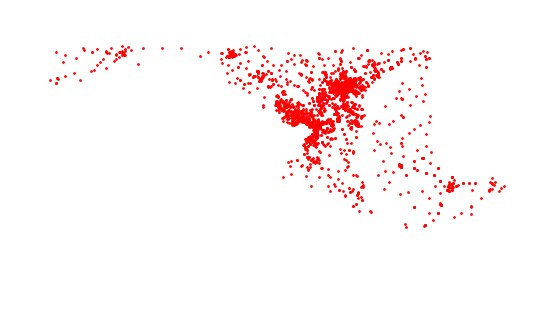

In [17]:
ax = md_2016_geo.plot(color = "red")
ax.set_axis_off()

Now merge the geocoded polling locations onto the overlapping census tract shapes.

In [18]:
query = """SELECT rn, ST_Transform(tr.geom, epsg) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
              tr.state  = rn.state AND tr.county = rn.county AND tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = 24;"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_map = gpd.GeoDataFrame.from_postgis(query, con, geom_col = "geometry", crs = from_epsg(epsg))

md_2016_merged = gpd.tools.sjoin(md_2016_geo, tr_map.to_crs(epsg = 4269), op = "within")
md_votes_2016 = md_2016_merged[["rn", "D16", "R16"]].groupby("rn").sum()

In [20]:
md_votes_2008 = gpd.read_file("md_2008.shp").groupby("rn").sum()[["D08", "R08"]]

In [21]:
md_votes = md_votes_2008.join(md_votes_2016, how = "outer").fillna(0).astype(int)
md_votes.index = md_votes.index.astype(int)

In [22]:
md_votes.to_csv("md_votes.csv")

Sanity check: did we preserve all of the votes from beginning to end?

In [23]:
test08 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/MD_%d.tab" % y, sep = "\t")
test16 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_state_2016.csv", 
                   usecols = ["County", "Election District", "Election Precinct", 
                              "Candidate Name", "Election Night Votes", "Office Name"], low_memory = False)

if not votes[2008].D08.sum() == test08.g2008_USP_dv.sum():
    print("problems in paradise -- 2008!!")
if not md_votes.D16.sum() == test16[test16["Candidate Name"] == "Hillary Clinton"]["Election Night Votes"].sum():
    print("2016 is fucked.")
else: print("nice work, stud.")

nice work, stud.


### Alternative: match unmatched precincts to the tract closest to the centroid of the election district.

In [256]:
md_2016 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_state_2016.csv", 
                      usecols = ["County", "Election District", "Election Precinct", 
                                 "Candidate Name", "Election Night Votes", "Office Name"], low_memory = False)
md_2016.rename(columns = {"County" : "md_id", "Election District" : "ed", "Election Precinct" : "precinct",
                          "Candidate Name" : "candidate", "Office Name" : "office", "Election Night Votes" : "votes"}, 
               inplace = True)
md_2016 = md_2016[(md_2016.candidate == "Donald J. Trump") | (md_2016.candidate == "Hillary Clinton")]
md_2016["party"] = "R16"
md_2016.loc[md_2016.candidate == "Hillary Clinton", "party"] = "D16"
md_2016 = pd.pivot_table(md_2016, values = "votes", index = ["md_id", "ed", "precinct"], columns = ["party"])
md_2016 = md_2016.reset_index()
md_2016 = pd.merge(md_2016, md_co_map, on = "md_id")
# md_2016 = md_2016[["cid", "ed", "precinct", "D16", "R16"]]

In [259]:
gdf = gpd.read_file("md_2008.shp")

In [260]:
m = pd.merge(gdf, md_2016, on = ["cid", "ed", "precinct"], how = "outer")
m = m.sort_values(by = ["cid", "ed", "precinct"])[["cid", "ed", "precinct", "rn", "geometry", "D08", "R08", "D16", "R16"]]
m.D08.fillna(0, inplace = True)
m.R08.fillna(0, inplace = True)
m.D16.fillna(0, inplace = True)
m.R16.fillna(0, inplace = True)

Because there are many more precincts in 2016 than in 2008 (it is growth in every case), I associate the extra precincts to the tract that is closest to the centroid of the election district.  Clearly, this is an imperfect solution, since in many cases the other precincts have moved or been renamed.

In [261]:
query = """SELECT DISTINCT ON (vtd.county, REGEXP_REPLACE(vtd, '-.*', '')::int)
               vtd.county cid,
               REGEXP_REPLACE(vtd, '-.*', '')::int ed,
               rn
            FROM vtd_2010 AS vtd
            JOIN census_tracts_2015 AS tr ON
               tr.state = vtd.state AND 
               (tr.county = vtd.county OR
                (tr.county = 5 AND vtd.county = 510))
            JOIN (SELECT state, county, tract,
                         row_number() over 
                           (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                  FROM census_tracts_2015) rn ON
                    tr.state  = rn.state  AND
                    tr.county = rn.county AND
                    tr.tract  = rn.tract
            WHERE
               vtd.state = 24 AND vtd != 'ZZZZZZ'
            GROUP BY vtd.county, REGEXP_REPLACE(vtd, '-.*', '')::int,
               tr.centroid, rn.rn
            ORDER BY 
               vtd.county,
               REGEXP_REPLACE(vtd, '-.*', '')::int,
               ST_Centroid(ST_Collect(vtd.geom)) <-> tr.centroid
            ;
           """

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

ed_tr = pd.read_sql(query, con)

In [262]:
for mi, mrow in m[m.geometry.isnull()].iterrows():
    m.loc[m.geometry.isnull() & (m.cid == mrow.cid) & (m.ed == mrow.ed), "rn"] = \
        ed_tr[(ed_tr.cid == mrow.cid) & (ed_tr.ed == mrow.ed)].rn.values[0]
    # print(ed_tr[(ed_tr.cid == mrow.cid) & (ed_tr.ed == mrow.ed)].rn.values[0])